# Experiment 1: MNIST

An attempt at putting the Fast.AI library to the test on the MNIST dataset and Kaggle competition.

## Downloading data.

Going to attempt to download the MNIST data using the Kaggle API. I've added my API token to the Kaggle config as follows:

```
$ mkdir ~/.kaggle
$ vi ~/.kaggle/kaggle.json
$ chmod 600 ~/.kaggle/kaggle.json
```

Then installed the Kaggle library as follows:

```
pip install kaggle
```

In [4]:
!kaggle competitions download -c digit-recognizer --path='./data/mnist-kaggle'

train.csv: Downloaded 73MB of 73MB
test.csv: Downloaded 49MB of 49MB
sample_submission.csv: Downloaded 235KB of 235KB


In [5]:
!ls -l ./data/mnist-kaggle/

total 125136
-rw-rw-r-- 1 lex lex   240909 Mar 28 01:21 sample_submission.csv
-rw-rw-r-- 1 lex lex 51118296 Mar 28 01:21 test.csv
-rw-rw-r-- 1 lex lex 76775041 Mar 28 01:21 train.csv


## Loading and exploring the data

In [1]:
import csv
import pprint

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
fh = open('./data/mnist-kaggle/train.csv')
csv_reader = csv.reader(fh)

In [3]:
header = next(csv_reader)

In [4]:
pprint.pprint(header[:10])

['label',
 'pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8']


In [5]:
print(f"Num of columns: {len(header[1:])}")

Num of columns: 784


The docs state that the images are all 24x24 and each pixel is represented by a number 0 to 1, which means the images are greyscale.

Let's explore a single image.

In [6]:
label, *img_data = next(csv_reader)

In [7]:
label

'1'

In [8]:
img_data[-10:]

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']

In [9]:
img_arr = np.array([int(i) for i in img_data])

In [10]:
img_arr.shape

(784,)

In [11]:
img_arr = img_arr.reshape((28, 28))

In [12]:
img_arr.shape

(28, 28)

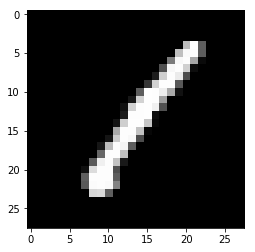

In [13]:
plt.imshow(img_arr, cmap='gray')

In [14]:
def load_img(img_data):
    img_arr = np.array([int(i) for i in img_data])
    img_arr = img_arr.reshape((28, 28))
    return img_arr

Now lets load all images into a `(m, 28, 28)` matrix, when m is the number of images in the training set.

In [15]:
fh.seek(0)
next(csv_reader)[:10]

['label',
 'pixel0',
 'pixel1',
 'pixel2',
 'pixel3',
 'pixel4',
 'pixel5',
 'pixel6',
 'pixel7',
 'pixel8']

In [16]:
line_count = 0
for line in csv_reader: line_count += 1

In [17]:
m = line_count

In [18]:
training_set = np.zeros((m, 28, 28), dtype=np.float32)
training_labels = np.zeros((m,), dtype=np.uint8)

In [19]:
fh.seek(0)
next(csv_reader)[:10]

for i, line in enumerate(csv_reader):
    label, *img_data = line
    training_set[i] = load_img(img_data)
    training_labels[i] = int(label)

9


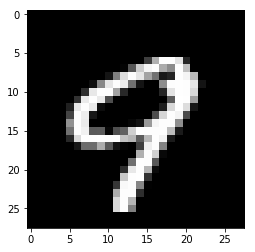

In [20]:
print(training_labels[100])
plt.imshow(training_set[100], cmap='gray')

5


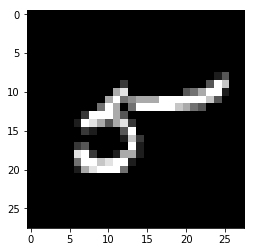

In [21]:
print(training_labels[1001])
plt.imshow(training_set[1001], cmap='gray')

8


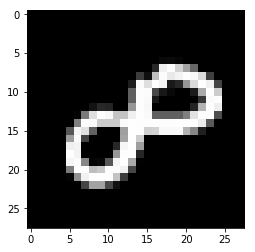

In [22]:
print(training_labels[8888])
plt.imshow(training_set[8888], cmap='gray')

Now save the data to prevent having to reprocess it.

In [23]:
np.save('data/mnist_training_imgs', training_set)
np.save('data/mnist_training_labels', training_labels)

## Loading the data from disk

In [24]:
all_imgs = np.load('data/mnist_training_imgs.npy')
all_labels = np.load('data/mnist_training_labels.npy')

## Training/validation split

We'll create a validation set with around 3000 images. Should be more than enough to validate the model's performance.

In [25]:
val_set_size = 3000
m

42000

In [26]:
indices = np.random.permutation(all_imgs.shape[0])
training_idx, val_idx = indices[:-val_set_size], indices[-val_set_size:]

training_set, val_set = all_imgs[training_idx], all_imgs[val_idx]
training_labels, val_labels = all_labels[training_idx], all_labels[val_idx]

In [27]:
print(training_set.shape)
print(training_labels.shape)

(39000, 28, 28)
(39000,)


In [28]:
print(val_set.shape)
print(val_labels.shape)

(3000, 28, 28)
(3000,)


## Training with Fast.AI

In [29]:
from torchvision.models import resnet18, resnet34, vgg16

from fastai.fastai.dataset import ImageClassifierData
from fastai.fastai.conv_learner import ConvLearner
from fastai.fastai.transforms import tfms_from_model

arch = resnet34

Since the lesson loads images from path and we have images in a NumPy array, it appears we use `from_arrays`. It appears to require an image with 3 channels, so adding them in as follows:

In [30]:
training_set  = np.stack((training_set,) * 3,axis=-1)
val_set = np.stack((val_set,) * 3,axis = -1)

In [31]:
training_set = training_set.transpose((0, 3, 1, 2))
val_set = val_set.transpose((0, 3, 1, 2))

In [32]:
print(training_set.shape)
print(val_set.shape)

(39000, 3, 28, 28)
(3000, 3, 28, 28)


In [33]:
# Note that the first argument is the paths for caching stuff.
data = ImageClassifierData.from_arrays(
    './data/mnist-kaggle/',
    trn=(training_set, training_labels.astype(np.int8)),
    val=(val_set, val_labels.astype(np.int8)))

In [34]:
type(data)

fastai.fastai.dataset.ImageClassifierData

In [35]:
data.val_y

array([3, 4, 2, ..., 6, 5, 6], dtype=int8)

In [36]:
data.classes

Since I know that the MNIST data is probably going to be quite different from ImageNet, I'm going to unfreeze all layers.

In [37]:
learn = ConvLearner.pretrained(arch, data, precompute=False)
learn.unfreeze()

In [38]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 81%|████████▏ | 496/610 [01:07<00:15,  7.32it/s, loss=1.17] 

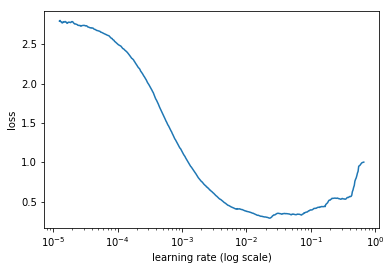

In [39]:
learn.sched.plot()

In [40]:
learn.fit(0.01, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

  3%|▎         | 17/610 [00:02<01:19,  7.45it/s, loss=1.42]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/lex/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      0.083585   0.070932   0.979341  
    1      0.040562   0.026866   0.993684                     
    2      0.029769   0.029936   0.990976                     
    3      0.026435   0.033247   0.990691                     



[0.03324664, 0.9906914893617021]

In [41]:
learn.fit(0.005, 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                      
    0      0.0134     0.019598   0.994016  
    1      0.010544   0.022888   0.993968                      
    2      0.006859   0.021287   0.994348                      
    3      0.007595   0.021191   0.993351                      



[0.021191258, 0.9933510638297872]